In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

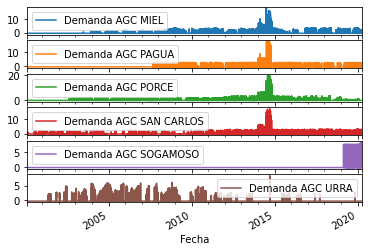

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2019-12-31']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2208, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
output_columns = inputs_columns

#inputs_columns = ['$kWh']
#output_columns = ['$kWh']

In [8]:
window_train = CustomWindowGenerator.MyWindowDatasetGenerator(data=train_df, times=24, shift=1,
                                                              input_signals=inputs_columns, output_signals=output_columns)

train_generator = window_train.make_dataset(train_df,batch_size=16,suffle=False)

In [9]:
window_val = CustomWindowGenerator.MyWindowDatasetGenerator(data=val_df, times=24, shift=1,
                                                            input_signals=inputs_columns, output_signals=output_columns)

val_generator = window_val.make_dataset(val_df,batch_size=16,suffle=False)

In [10]:
window_test = CustomWindowGenerator.MyWindowDatasetGenerator(data=test_df, times=24, shift=24,
                                                             input_signals=inputs_columns, output_signals=output_columns)

test_generator = window_test.make_dataset(test_df,batch_size=16,suffle=False,sequence_stride=24)

# MODELS

## Instantiate Models

In [11]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [12]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [13]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [14]:
def generate_predictions_style_1(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]
        num_inputs_signals = batch.shape[1]
        num_labels_signals = labels.shape[2]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = tf.reshape(batch[i:24,:], [-1,num_inputs_signals])
            last_signals = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,num_labels_signals])
            
            signals_to_predict = tf.concat([first_signals,last_signals],axis=0)

            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [15]:
def plot_comparison(inputs,predictions):
    signal_true = inputs[:,:,-1]
    flat_signal_true = tf.reshape(signal_true, [-1,1])

    signal_pred = predictions[:,:,-1]
    flat_signal_pred = tf.reshape(signal_pred, [-1,1])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(flat_signal_true, label='true')
    plt.plot(flat_signal_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

In [16]:
def find_metrics_test(y_true,y_pred):
    
    mae_call = tf.keras.metrics.MeanAbsoluteError()
    mae_call.update_state(y_true,y_pred)
    mae = mae_call.result().numpy()
    
    mape_call = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_call.update_state(y_true,y_pred)
    mape = mape_call.result().numpy()
    
    sMAPE_call = CustomMetrics.symmetric_mean_absolute_percentage_error(y_true,y_pred)
    sMAPE = sMAPE_call.numpy()
    
    return [mae,mape,sMAPE]

## Execute experiments

### Recurrent Neuronal Network

In [17]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 16)                1344      
Total params: 9,644
Trainable params: 9,644
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = compile_and_fit(model=custom_rnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
  1/300 [..............................] - ETA: 0s - loss: 1.0122 - mean_absolute_error: 0.8271 - mean_absolute_percentage_error: 224.6644 - symmetric_mean_absolute_percentage_error: 34778.4297WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
300/300 [==============================] - 8s 27ms/step - loss: 0.2702 - mean_absolute_error: 0.3720 - mean_absolute_percentage_error: 205.9768 - symmetric_mean_absolute_percentage_error: 19734.3926 - val_loss: 1.1566 - val_mean_absolute_error: 0.8636 - val_mean_absolute_percentage_error: 399.5120 - val_symmetric_mean_absolute_percentage_error: 31985.7500
Epoch 2/100
300/300 [==============================] - 7s 24ms/step - loss: 0.2933 - mean_absolute_error: 0.3748 - mean_absolute_p

In [19]:
val_performance['DNN'] = custom_rnn.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 0.7502 - mean_absolute_error: 0.6390 - mean_absolute_percentage_error: 283.4736 - symmetric_mean_absolute_percentage_error: 24899.5410


In [20]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

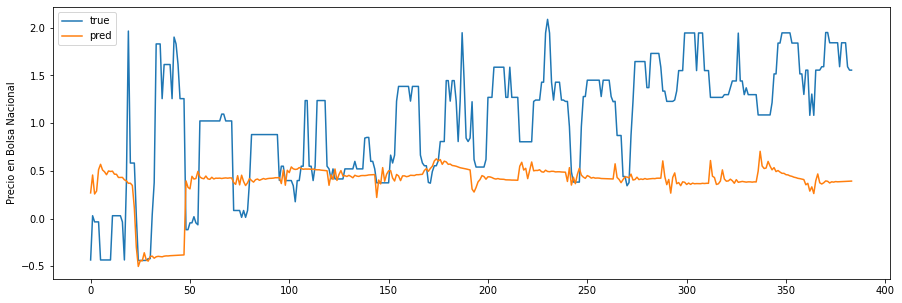

In [21]:
predictions = generate_predictions_style_1(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

In [22]:
performance['RNN'] = find_metrics_test(labels,predictions)

### Long Short Term Memory

In [23]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                33200     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1344      
Total params: 34,544
Trainable params: 34,544
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = compile_and_fit(model=custom_lstm, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 5s 16ms/step - loss: 0.2464 - mean_absolute_error: 0.3366 - mean_absolute_percentage_error: 186.6193 - symmetric_mean_absolute_percentage_error: 18385.9141 - val_loss: 0.9591 - val_mean_absolute_error: 0.8060 - val_mean_absolute_percentage_error: 405.6981 - val_symmetric_mean_absolute_percentage_error: 33045.5547
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 0.2679 - mean_absolute_error: 0.3516 - mean_absolute_percentage_error: 143.0541 - symmetric_mean_absolute_percentage_error: 18848.6914 - val_loss: 0.8604 - val_mean_absolute_error: 0.7362 - val_mean_absolute_percentage_error: 261.4878 - val_symmetric_mean_absolute_percentage_error: 29622.7109
Epoch 3/100
300/300 [==============================] - 3s 9ms/step - loss: 0.2631 - mean_absolute_error: 0.3508 - mean_absolute_percentage_error: 159.1726 - symmetric_mean_absolute_percentage_error: 16888.7852 - val_loss: 0.7622 - val_mean_absolute_error: 0.659

Epoch 21/100
300/300 [==============================] - 3s 10ms/step - loss: 0.2793 - mean_absolute_error: 0.3431 - mean_absolute_percentage_error: 157.8581 - symmetric_mean_absolute_percentage_error: 16673.5059 - val_loss: 0.6408 - val_mean_absolute_error: 0.5612 - val_mean_absolute_percentage_error: 315.4578 - val_symmetric_mean_absolute_percentage_error: 22432.6875
Epoch 22/100
300/300 [==============================] - 3s 10ms/step - loss: 0.2721 - mean_absolute_error: 0.3489 - mean_absolute_percentage_error: 162.1818 - symmetric_mean_absolute_percentage_error: 16468.3086 - val_loss: 0.6460 - val_mean_absolute_error: 0.5631 - val_mean_absolute_percentage_error: 292.6819 - val_symmetric_mean_absolute_percentage_error: 22606.5742
Epoch 23/100
300/300 [==============================] - 3s 11ms/step - loss: 0.3017 - mean_absolute_error: 0.3716 - mean_absolute_percentage_error: 226.8443 - symmetric_mean_absolute_percentage_error: 16842.8457 - val_loss: 0.6502 - val_mean_absolute_error: 

In [25]:
val_performance['LSTM'] = custom_lstm.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 0.7005 - mean_absolute_error: 0.5923 - mean_absolute_percentage_error: 273.7694 - symmetric_mean_absolute_percentage_error: 23410.5430


In [26]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

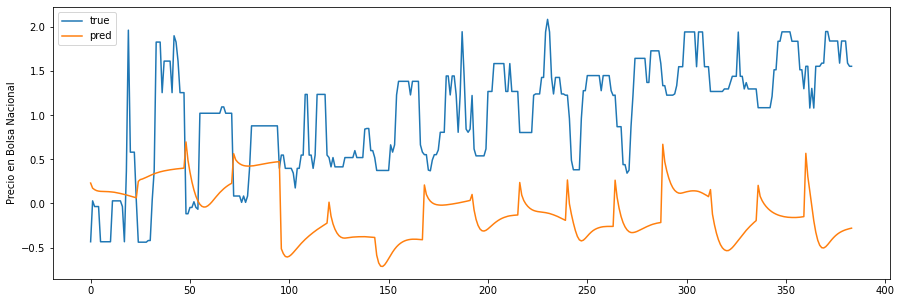

In [27]:
predictions = generate_predictions_style_1(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

In [28]:
performance['LSTM'] = find_metrics_test(labels,predictions)

### Gated Recurrent Unit

In [29]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                25149     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1344      
Total params: 26,493
Trainable params: 26,493
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = compile_and_fit(model=custom_gru, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 25s 85ms/step - loss: 0.2445 - mean_absolute_error: 0.3437 - mean_absolute_percentage_error: 189.0624 - symmetric_mean_absolute_percentage_error: 18720.3691 - val_loss: 1.0663 - val_mean_absolute_error: 0.8256 - val_mean_absolute_percentage_error: 345.6205 - val_symmetric_mean_absolute_percentage_error: 34010.8242
Epoch 2/100
300/300 [==============================] - 23s 76ms/step - loss: 0.2526 - mean_absolute_error: 0.3362 - mean_absolute_percentage_error: 142.6583 - symmetric_mean_absolute_percentage_error: 17876.1367 - val_loss: 0.8765 - val_mean_absolute_error: 0.7085 - val_mean_absolute_percentage_error: 421.7488 - val_symmetric_mean_absolute_percentage_error: 28489.5137
Epoch 3/100
300/300 [==============================] - 21s 71ms/step - loss: 0.2426 - mean_absolute_error: 0.3219 - mean_absolute_percentage_error: 148.7734 - symmetric_mean_absolute_percentage_error: 15400.8564 - val_loss: 0.7862 - val_mean_absolute_error: 

Epoch 21/100
300/300 [==============================] - 22s 72ms/step - loss: 0.2698 - mean_absolute_error: 0.3278 - mean_absolute_percentage_error: 158.8689 - symmetric_mean_absolute_percentage_error: 15780.9385 - val_loss: 0.6553 - val_mean_absolute_error: 0.5517 - val_mean_absolute_percentage_error: 250.7639 - val_symmetric_mean_absolute_percentage_error: 22084.9922
Epoch 22/100
300/300 [==============================] - 21s 72ms/step - loss: 0.2631 - mean_absolute_error: 0.3332 - mean_absolute_percentage_error: 169.4490 - symmetric_mean_absolute_percentage_error: 15755.3184 - val_loss: 0.6612 - val_mean_absolute_error: 0.5517 - val_mean_absolute_percentage_error: 265.9878 - val_symmetric_mean_absolute_percentage_error: 22074.0254
Epoch 23/100
300/300 [==============================] - 21s 71ms/step - loss: 0.2902 - mean_absolute_error: 0.3495 - mean_absolute_percentage_error: 200.4631 - symmetric_mean_absolute_percentage_error: 15824.4170 - val_loss: 0.6590 - val_mean_absolute_erro

In [31]:
val_performance['GRU'] = custom_gru.evaluate(val_generator)

546/546 [==============================] - 3s 6ms/step - loss: 0.7252 - mean_absolute_error: 0.5792 - mean_absolute_percentage_error: 261.4886 - symmetric_mean_absolute_percentage_error: 22455.7500


In [32]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

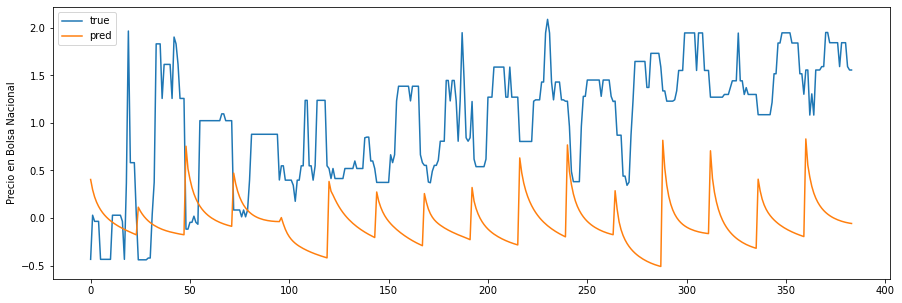

In [33]:
predictions = generate_predictions_style_1(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

In [34]:
performance['GRU'] = find_metrics_test(labels,predictions)

### Convolutional Neuronal Network

In [35]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [36]:
history = compile_and_fit(model=custom_cnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 4s 15ms/step - loss: 0.4578 - mean_absolute_error: 0.5226 - mean_absolute_percentage_error: 259.9713 - symmetric_mean_absolute_percentage_error: 24715.0215 - val_loss: 3.1751 - val_mean_absolute_error: 1.4357 - val_mean_absolute_percentage_error: 1255.0690 - val_symmetric_mean_absolute_percentage_error: 39132.0898
Epoch 2/100
294/300 [============================>.] - ETA: 0s - loss: 0.4210 - mean_absolute_error: 0.4871 - mean_absolute_percentage_error: 190.9480 - symmetric_mean_absolute_percentage_error: 24595.1934
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
300/300 [==============================] - 2s 7ms/step - loss: 0.4211 - mean_absolute_error: 0.4872 - mean_absolute_percentage_error: 189.2656 - symmetric_mean_absolute_percentage_error: 24569.5664 - val_loss: 3.5868 - val_mean_absolute_error: 1.5127 - val_mean_absolute_percentage_error: 775.1279 - val_symmetric_mean_absolute_percentage_err

Epoch 21/100
300/300 [==============================] - 2s 7ms/step - loss: 0.6263 - mean_absolute_error: 0.6228 - mean_absolute_percentage_error: 163.3094 - symmetric_mean_absolute_percentage_error: 31299.5195 - val_loss: 2.6261 - val_mean_absolute_error: 1.3307 - val_mean_absolute_percentage_error: 848.1163 - val_symmetric_mean_absolute_percentage_error: 39081.9180
Epoch 22/100
300/300 [==============================] - 2s 7ms/step - loss: 0.6805 - mean_absolute_error: 0.6514 - mean_absolute_percentage_error: 217.5277 - symmetric_mean_absolute_percentage_error: 30655.5332 - val_loss: 2.6064 - val_mean_absolute_error: 1.3211 - val_mean_absolute_percentage_error: 860.9185 - val_symmetric_mean_absolute_percentage_error: 36829.8516
Epoch 23/100
300/300 [==============================] - 2s 7ms/step - loss: 0.7496 - mean_absolute_error: 0.7005 - mean_absolute_percentage_error: 294.4919 - symmetric_mean_absolute_percentage_error: 32201.4434 - val_loss: 2.1997 - val_mean_absolute_error: 1.2

In [37]:
val_performance['CNN'] = custom_cnn.evaluate(val_generator)

546/546 [==============================] - 2s 3ms/step - loss: 2.3810 - mean_absolute_error: 1.2552 - mean_absolute_percentage_error: 591.0819 - symmetric_mean_absolute_percentage_error: 38669.1367


In [38]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

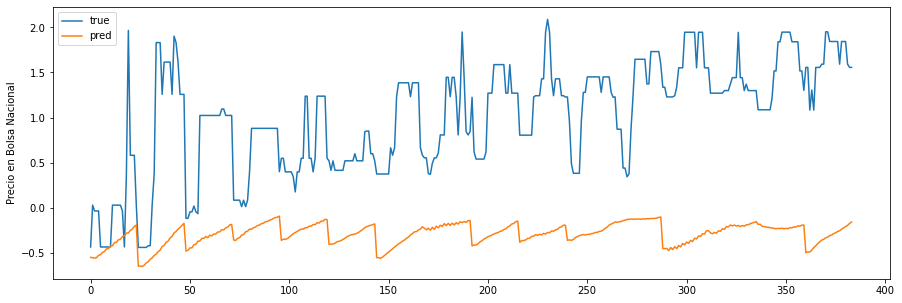

In [39]:
predictions = generate_predictions_style_1(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

In [40]:
performance['CNN'] = find_metrics_test(labels,predictions)

## Metrics Summary

In [41]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.750228,0.639027,283.473572,24899.541016
LSTM,0.700457,0.592277,273.769409,23410.542969
GRU,0.725173,0.579242,261.488556,22455.750000
CNN,2.381022,1.255191,591.081909,38669.136719


In [42]:
pd.DataFrame(performance,index=['Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
RNN,0.959264,217.529770,52483.569336
LSTM,1.045153,243.200912,54184.741211
GRU,1.000185,273.403076,53807.421875
CNN,1.150887,257.458832,62846.960449
